# Decision Tree Regressor Model

## Libraries

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import pearsonr


In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Paths

In [12]:
DATA_ROOT = "./gaitrec_data"
# Train set
UNBALANCED_TRAIN_SET_METADATA_PATH = os.path.join(DATA_ROOT, "unbalanced_train_set_metadata.csv")
POSTPROCESSED_TRAIN_FOLDER = os.path.join(DATA_ROOT, 'postprocessed_train')
GROUPS_SESSIONS_DATA_TRAIN = os.path.join(DATA_ROOT, 'groups_sessions_data_train')
GRF_F_AP_PRO_DATA_TRAIN = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_train')
# Test set
TEST_SET_METADATA_PATH = os.path.join(DATA_ROOT, "test_set_metadata.csv")
TEST_FOLDER = os.path.join(DATA_ROOT, "test_set")
GROUPS_SESSIONS_DATA_TEST = os.path.join(DATA_ROOT, 'groups_sessions_data_test')
GRF_F_AP_PRO_DATA_TEST = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_test')

## Separar las features del target

- Separar las features (valores de la primera sesión) y el target (valores de la última sesión).
- Los valores de la primera sesión corresponden a las filas impares y los valores de la última sesión corresponden a las filas pares. 

In [13]:
def split_df_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # Select only the columns of interest
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    # Create X_train, y_train, X_test, y_test:
        # Extract the odd rows into X
        # Extract the even rows into y
    X_train = df_train.iloc[::2][columns_of_interest].values
    y_train = df_train.iloc[1::2][columns_of_interest].values
    X_test = df_test.iloc[::2][columns_of_interest].values
    y_test = df_test.iloc[1::2][columns_of_interest].values

    return X_train, y_train, X_test, y_test

## Load preprocessed data
- ANKLE data - 2 sessions

In [14]:
# train df
combined_legs_2sessions_A_train = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TRAIN, 
                              'groups_2sessions_data_train/A_data/combined.csv'))
# test df
combined_legs_2sessions_A_test = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TEST, 
                              'groups_2sessions_data_test/A_data/combined.csv'))

## Train - Test split

In [15]:
# train - test split 
X_train_A2, y_train_A2, X_test_A2, y_test_A2 = split_df_train_test(
                                                df_train = combined_legs_2sessions_A_train, 
                                                df_test = combined_legs_2sessions_A_test)

## Model 6: Decision Trees Regressor

### Training the Decision Tree Regressor

In [ ]:
# Function to train and evaluate a Decision Tree model
def train_and_evaluate_decision_tree(X_train, y_train):
    """
    Train and evaluate a Decision Tree model with hyperparameter tuning.

    Parameters:
        X_train (np.ndarray): Training data with shape (num_samples, num_features).
        y_train (np.ndarray): Training target data with shape (num_samples, num_targets).

    Returns:
        DecisionTreeRegressor: Fitted Decision Tree model.
        float: Root mean square error (RMSE) score.
        float: R-squared score.
        float: Correlation coefficient (Pearson's r).
    """
    # Initialize a Decision Tree model
    decision_tree = DecisionTreeRegressor(random_state=42)

    # Define a range of hyperparameters for tuning
    param_grid = {
        # 'criterion': ['poisson', 'absolute_error', 'friedman_mse', 'squared_error'], # to specify the function to measure the quality of a split
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60], # The maximum depth of a decision tree is the length of the longest path from the tree's root to a leaf.
                                                                                  # Shallower trees are generally easier to interpret. 
        'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40], # The minimum number of samples required to split an internal node.  
                                                        # min_samples_split is used to control over-fitting. 
                                                        # The ideal min_samples_split values tend to be between 1 to 40 for the CART algorithm. 
        'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] # The minimum number of samples required to be at a leaf node. 
                                         # A split point at any depth will only be considered if it leaves at least min_samples_leaf training 
                                         # samples in each of the left and right branches. 
                                         # This may have the effect of smoothing the model, especially in regression.
                                         # min_samples_leaf is also used to control over-fitting by defining that each leaf has more than one element.
                                         # The ideal min_samples_leaf values tend to be between 1 to 20 for the CART algorithm.
    }

    # Create GridSearchCV object with 10-fold cross-validation
    grid_search = GridSearchCV(decision_tree, 
                               param_grid, 
                               cv=10, 
                               scoring=make_scorer(mean_squared_error, 
                                                   squared=False, 
                                                   greater_is_better=False), # the same: scoring='neg_mean_squared_error'
                                n_jobs=-1)  # Use all available CPU cores for parallel computation) 


    # Fit the GridSearchCV object on the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Train the Decision Tree model with the best hyperparameters
    best_decision_tree = DecisionTreeRegressor(**best_params, random_state=42)
    best_decision_tree.fit(X_train, y_train)

    # Perform cross-validation and get predicted values
    predicted_y = cross_val_predict(best_decision_tree, X_train, y_train, cv=10)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_train, predicted_y))

    # Calculate R2 score
    r2 = r2_score(y_train, predicted_y)

    # Calculate correlation coefficient
    corr_coeff, _ = pearsonr(y_train.flatten(), predicted_y.flatten())

    # Print the results
    print("Results on Training Set:")
    print(f" RMSE: {rmse:.3f}")
    print(f" R2 Score: {r2:.3f}")
    print(f" Correlation coefficient: {corr_coeff:.3f}")

    return best_decision_tree, rmse, r2, corr_coeff

In [44]:
# Train and evaluate the Decision Tree (model 6)
decision_tree_model, rmse_decision_tree, r2_decision_tree, corr_decision_tree = train_and_evaluate_decision_tree(X_train_A2, y_train_A2)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 2}
Results on Training Set:
 RMSE: 0.021
 R2 Score: 0.195
 Correlation coefficient: 0.974


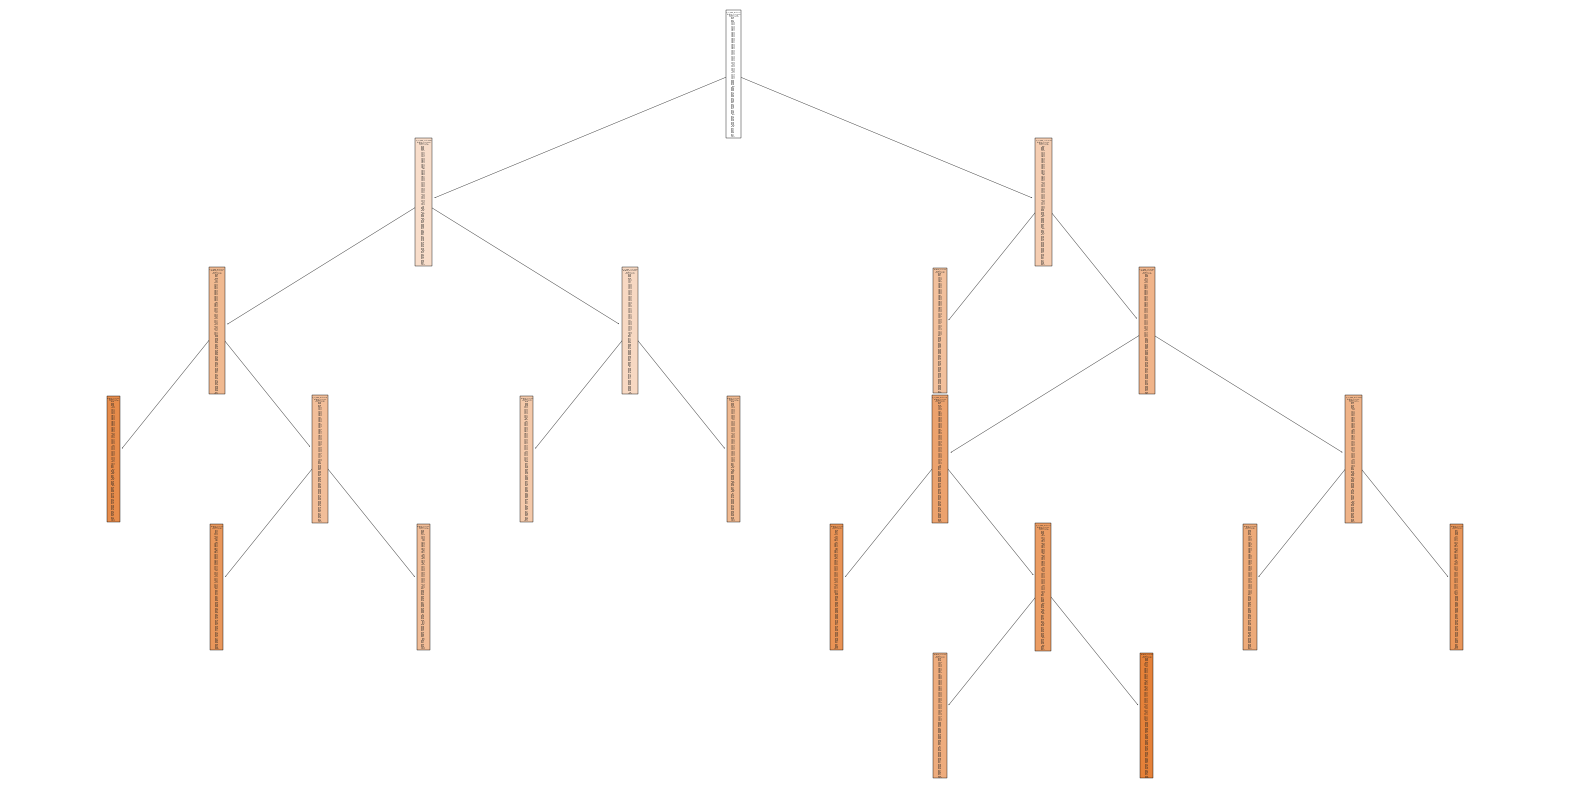

In [60]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, filled=True, feature_names=combined_legs_2sessions_A_train.columns[3:].tolist())
plt.show()

### Model evaluation

#### Evaluation pipeline

In [18]:
def evaluate_PLS_model_on_test_set(model, X_test, y_test):
    """
    Evaluate the fitted PLS model on the test set.

    Parameters:
        model (PLSRegression): Fitted PLS model.
        X_test (np.ndarray): Test data with shape (num_samples, num_features).
        y_test (np.ndarray): True test target data with shape (num_samples, num_targets).

    Returns:
        List[float]: List of root mean square error (RMSE) scores for each target variable.
        float: Overall root mean square error (RMSE) score averaged across all target variables.
        List[float]: List of correlation coefficients (Pearson's r) for each target variable.
        float: Overall correlation coefficient (Pearson's r) across all target variables.
        List[float]: List of coefficient of determination (R-squared) for each target variable.
        float: Overall coefficient of determination (R-squared) across all target variables.
        List[float]: List of adjusted R-squared for each target variable.
        float: Overall adjusted R-squared across all target variables.
        np.ndarray: Predicted target values for the test set with shape (num_samples, num_targets).
    """
    num_targets = y_test.shape[1]
    rmse_scores_test = []
    correlation_coeffs = []
    coeff_determination_r2 = []
    adj_r_squared = []

    # Apply the dimension reduction learned on the train data.
    y_pred_test = model.predict(X_test)

    for i in range(num_targets):
        y_test_single = y_test[:, i]
        y_pred = y_pred_test[:, i]

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_single, y_pred)) # this also works: rmse = np.sqrt(np.average((y_test_single - y_pred)**2, axis=0))
        rmse_scores_test.append(rmse)

        # Calculate correlation coefficient (Pearson's r)
        corr_coeff, _ = pearsonr(y_test_single, y_pred)
        correlation_coeffs.append(corr_coeff)

        # Calculate coefficient of determination (R-squared)
        r2 = r2_score(y_test_single, y_pred)
        coeff_determination_r2.append(r2)

        # Calculate adjusted R-squared
        n = len(y_test_single)  # number of samples
        p = X_test.shape[1] - 1  # number of predictors (excluding the constant term)
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # formula of adjusted R-squared
        adj_r_squared.append(adj_r2)

    # Calculate overall RMSE
    # overall_rmse = np.sqrt(np.mean(np.array(rmse_scores_test) ** 2))
    overall_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    # Calculate overall correlation coefficient
    overall_corr_coeff, _ = pearsonr(y_test.flatten(), y_pred_test.flatten())

    # Calculate overall coefficient of determination (R-squared)
    overall_coeff_determination_r2 = r2_score(y_test, y_pred_test)

    # Calculate overall adjusted R-squared
    overall_adj_r_squared = 1 - ((1 - overall_coeff_determination_r2) * (len(y_test.flatten()) - 1) / (len(y_test.flatten()) - len(X_test[0]) + 1))

    return rmse_scores_test, overall_rmse, correlation_coeffs, overall_corr_coeff, coeff_determination_r2, overall_coeff_determination_r2, overall_adj_r_squared, y_pred_test


def plot_predictions_vs_true(y_true: np.ndarray, 
                             y_pred: np.ndarray, 
                             rmse_scores_test: list[float],
                             corr_target_test: list[float]) -> None:
    """
    Plot scatter plots of predicted values against true values for each target variable.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        rmse_scores_test (list[float]): List of RMSE scores for each target variable on the test set.
        correlations (list[float]): List of correlation coefficients for each target variable. 

    Returns:
        None
    """
    num_targets = y_true.shape[1]
    num_rows = int(np.ceil(num_targets / 5))
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    for target in range(num_targets):
        axes[target].scatter(y_true[:, target], y_pred[:, target], alpha=0.6)
        # the dashed line represents the perfect correlation line between the true and predicted values
        axes[target].plot([y_true[:, target].min(), y_true[:, target].max()],
                          [y_true[:, target].min(), y_true[:, target].max()],
                          color='red', linestyle='dashed')
        axes[target].set_xlabel('True Values')
        axes[target].set_ylabel('Predicted Values')
        axes[target].set_title(f"Target {target + 1}: Predicted vs True Values\nRMSE: {rmse_scores_test[target]:.3f}   Corr: {corr_target_test[target]:.3f}")

    # Hide empty subplots, if any
    for i in range(num_targets, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


from scipy.stats import linregress
def plot_correlation_model(y_true: np.ndarray, 
                           y_pred: np.ndarray, 
                           overall_corr_coeff: float) -> None:
    """
    Create a global correlation plot of the model's predictions with all points and a reference line.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_corr_coeff (float): Overall correlation coefficient (Pearson's r) across all target variables.

    Returns:
        None
    """

    # Flatten the true and predicted values
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Create a scatter plot of true values against predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.7)

    # # Calculate the linear regression line parameters
    # slope, intercept, r_value, p_value, std_err = linregress(y_true_flat, y_pred_flat)
    # line = slope * y_true_flat + intercept
    # # Plot the linear regression line
    # plt.plot(y_true_flat, line, color='red', label='Regression Line')

    # Plot the reference line for perfect correlation:
    """
    The red line in the scatter plot is a reference line that represents a perfect correlation 
    between the true values and the predicted values. In other words, if all the data points were exactly 
    on this line, it would mean that the predicted values perfectly match the true values. 
    The slope of this line is 1, and it passes through the origin (0,0)."
    """
    plt.plot(y_true_flat, y_true_flat, color='red', linestyle='-', label='Perfect Correlation Line')


    # Add labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Correlation Plot of Model Predictions')

    # Annotate the overall correlation coefficient on the plot
    plt.text(0.02, 0.9, f'Overall Correlation (Pearson r = {overall_corr_coeff:.3f})', transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # Add legend with Perfect Correlation Line
    plt.legend(loc='best')

    plt.show()

def plot_last_session_mean_prediction_vs_mean_true(y_true: np.ndarray, 
                                                   y_pred: np.ndarray, 
                                                   overall_rmse: float,
                                                   overall_corr: float,
                                                   overall_r2: float,
                                                   overall_adj_r2: float,
                                                   time_points: int = 101,
                                                   x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_rmse (float): The overall root mean square error (RMSE) of the model.
        overall_corr (float): The overall correlation coefficient of the model.
        overall_r2 (float): The overall coefficient of determination (R-squared) of the model.
        overall_adj_r2 (float): The overall adjusted R-squared of the model.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """
    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = [str(num) for num in range(time_points)]

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Plot the lines
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, mean_y_pred, label='Last Session Mean Prediction')
    plt.plot(x_axis, mean_y_true, label='Last Session Mean True')

    # Add overall RMSE, overall correlation and overall R2 as text in the plot
    plt.text(0.75, 0.31, f"RMSE: {overall_rmse:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.text(0.75, 0.25, f"Correlation: {overall_corr:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.text(0.75, 0.19, f"R-squared: {overall_r2:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.text(0.75, 0.13, f"Adj. R-squared: {overall_adj_r2:.3f}", transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
             
    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction vs Last Session Mean True')

    # Customize x-axis ticks and labels
    x_ticks = range(0, len(x_axis), x_ticks)
    x_tick_labels = [x_axis[i] for i in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for mean and standard deviation
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def calculate_HC_mean(group:str, num_sessions: int = 2):
    # Session folder
    session_folder = os.path.join(GROUPS_SESSIONS_DATA_TRAIN, f'groups_{num_sessions}sessions_data_train')

    # Group folders
    hc_folder = os.path.join(session_folder, 'HC_data')
    group_folder = os.path.join(session_folder, f'{group}_data')

    # Dictionary to store HC mean lines per common CSV filename
    hc_means = {}

    # Iterate over the CSV files in the HC folder
    for hc_filename in os.listdir(hc_folder):
        if hc_filename.endswith(".csv"):
            # HC file path
            hc_filepath = os.path.join(hc_folder, hc_filename)
            # Read the HC CSV file
            hc_df = pd.read_csv(hc_filepath)
            # Extract common filename part
            common_filename = hc_filename.split("_train_")[0]
            # Calculate mean line of HC and store it in the dictionary
            hc_means[common_filename] = np.mean(hc_df.iloc[:, 3:].values, axis=0)

    return hc_means[common_filename]


def plot_system_output(hc_means: np.ndarray,
                       first_session: np.ndarray, # 1st session (X_test)
                       y_true: np.ndarray, # last session true
                       y_pred: np.ndarray,# last session pred
                       overall_rmse: float,
                       overall_corr: float, 
                       overall_r2: float,
                       overall_adj_r2: float,
                       time_points: int = 101,
                       x_ticks: int = 10,
                       text_x: float = 0.75,
                       text_y: float = 0.31) -> None:
    """
    Plot mean prediction values against mean true values for each target variable.

    Parameters:
        hc_means (np.ndarray): The mean values of healthy controls for each target variable.
        first_session (np.ndarray): The mean values of the first session for each target variable.
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        overall_rmse (float): The overall root mean square error (RMSE) of the model.
        overall_corr (float): The overall correlation coefficient of the model.
        overall_r2 (float): The overall coefficient of determination (R-squared) of the model.
        overall_adj_r2 (float): The overall adjusted R-squared of the model.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.
        text_x (float): The position to place the text (x axis). By default, this is in data coordinates. % of the width of the axes
        text_y (float): The position to place the text (y axis). By default, this is in data coordinates. % of the height of the axes.

    Returns:
        None
    """
    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = [str(num) for num in range(time_points)]

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_first_session = np.mean(first_session, axis=0)
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Plot the lines
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, hc_means, label='HC Mean', color='black')
    plt.plot(x_axis, mean_first_session, label='First Session Mean', color='red')
    plt.plot(x_axis, mean_y_true, label='Last Session Mean True', color='green')
    plt.plot(x_axis, mean_y_pred, label='Last Session Mean Prediction', color='blue')

    # # Add overall RMSE, overall correlation and overall R2 as text in the plot
    # plt.text(0.75, 0.31, f"RMSE: {overall_rmse:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # plt.text(0.75, 0.25, f"Correlation: {overall_corr:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # plt.text(0.75, 0.19, f"R-squared: {overall_r2:.3f}", transform=plt.gca().transAxes,
    #          fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # plt.text(0.75, 0.13, f"Adj. R-squared: {overall_adj_r2:.3f}", transform=plt.gca().transAxes,
    #         fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # Add overall RMSE, overall correlation and overall R2 as text in the plot
    # Concatenate the strings for all the metrics
    metrics_text = f"RMSE: {overall_rmse:.3f}\n"
    metrics_text += f"Correlation: {overall_corr:.3f}\n"
    metrics_text += f"R-squared: {overall_r2:.3f}\n"
    metrics_text += f"Adj. R-squared: {overall_adj_r2:.3f}"

    # Add the concatenated text as a single text box in the plot
    plt.text(text_x, text_y, metrics_text, transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('HC mean vs 1st Session Mean vs Last Session Mean True vs Last Session Mean Prediction')

    # Customize x-axis ticks and labels
    x_ticks = range(0, len(x_axis), x_ticks)
    x_tick_labels = [x_axis[i] for i in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


from matplotlib.collections import LineCollection

def plot_last_session_mean_prediction_with_rmse(y_true: np.ndarray, 
                                                y_pred: np.ndarray, 
                                                rmse_scores_test: list[float],
                                                time_points: int = 101,
                                                x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with RMSE color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        rmse_scores_test (list[float]): List of RMSE scores for each target variable on the test set.
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for RMSE values
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with RMSE color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(rmse_scores_test), 
                                           vmax=max(rmse_scores_test)), 
                        linewidth=3)
    lc.set_array(np.array(rmse_scores_test))

    # Plot the LineCollection
    plt.figure(figsize=(12, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    
    # Add colorbar for RMSE values
    cbar = plt.colorbar(lc, label='RMSE')

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction with RMSE Color Encoding')

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for target variables
    #plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def plot_last_session_mean_prediction_with_corr(y_true: np.ndarray, 
                                                y_pred: np.ndarray, 
                                                corr_target_test: list[float],
                                                time_points: int = 101,
                                                x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with correlation coefficient color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        corr_target_test (list[float]): List of correlation coefficients for each target variable. 
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for correlation coefficients
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with orrelation coefficient color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(corr_target_test), 
                                           vmax=max(corr_target_test)), 
                        linewidth=3)
    lc.set_array(np.array(corr_target_test))

    # Plot the LineCollection
    plt.figure(figsize=(12, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    
    # Add colorbar for correlation coefficient values
    cbar = plt.colorbar(lc, label='Correlation Coefficient')

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction with Correlation Coefficient Color Encoding')

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for target variables
    #plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_last_session_mean_prediction_with_r2(y_true: np.ndarray, 
                                            y_pred: np.ndarray, 
                                            r_squared: list[float],
                                            time_points: int = 101,
                                            x_ticks: int = 10) -> None:
    """
    Plot mean prediction values against mean true values for each target variable with correlation coefficient color encoding.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        corr_target_test (list[float]): List of correlation coefficients for each target variable. 
        time_points (int): Number of time points.
        x_ticks (int): Interval for x-axis ticks.

    Returns:
        None
    """

    # Create the x-axis with values from 0 to 100 (time points)
    x_axis = np.arange(0, time_points)

    # Calculate mean values for predictions and true values across all patients for each target variable
    mean_y_pred = np.mean(y_pred, axis=0)
    mean_y_true = np.mean(y_true, axis=0)

    # Create colormap for correlation coefficients
    colormap =  plt.colormaps.get_cmap('coolwarm')


    # Create line segments for LineCollection
    segments = np.stack((x_axis, mean_y_pred), axis=-1)
    segments = [[[x0, y0], [x1, y1]] for (x0, y0), (x1, y1) in zip(segments[:-1], segments[1:])]

    # Create LineCollection with orrelation coefficient color encoding
    lc = LineCollection(segments, 
                        cmap=colormap, 
                        norm=plt.Normalize(vmin=min(r_squared), 
                                           vmax=max(r_squared)), 
                        linewidth=3)
    lc.set_array(np.array(r_squared))

    # Plot the LineCollection
    plt.figure(figsize=(12, 6))
    plt.gca().add_collection(lc)
    plt.gca().autoscale()
    
    # Add colorbar for correlation coefficient values
    cbar = plt.colorbar(lc, label='R-squared')

    # Add labels and title
    plt.xlabel('Stance (%)')
    plt.ylabel('Body weight (%)')
    plt.title('Last Session Mean Prediction with R-squared Color Encoding')

    # Customize x-axis ticks and labels
    x_ticks = np.arange(0, time_points, x_ticks)
    x_tick_labels = [str(num) for num in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add legend for target variables
    #plt.legend(loc='best')
    plt.grid(True)
    plt.show()

#### Decision Tree Regressor model 6 evaluation

In [47]:
# Model 6 (Decision Tree Regressor) evaluation on the test set
rmse_scores_test_A2, overall_rmse_test_A2, corr_target_test_A2, overall_corr_test_A2, \
R2_target_test_A2, overall_R2_test_A2, overall_adj_R2_test_A2, \
y_pred_test_A2 = evaluate_PLS_model_on_test_set(
    model=decision_tree_model, 
    X_test=X_test_A2, 
    y_test=y_test_A2)

print("Results on Test Set:")
print(f" Overall RMSE: {overall_rmse_test_A2:.3f}")
print(f" Overall Correlation Coefficient: {overall_corr_test_A2:.3f}")
print(f" Overall R-squared: {overall_R2_test_A2:.3f}")
print(f" Overall Adjusted R-squared: {overall_adj_R2_test_A2:.3f}")

Results on Test Set:
 Overall RMSE: 0.018
 Overall Correlation Coefficient: 0.980
 Overall R-squared: 0.072
 Overall Adjusted R-squared: 0.053


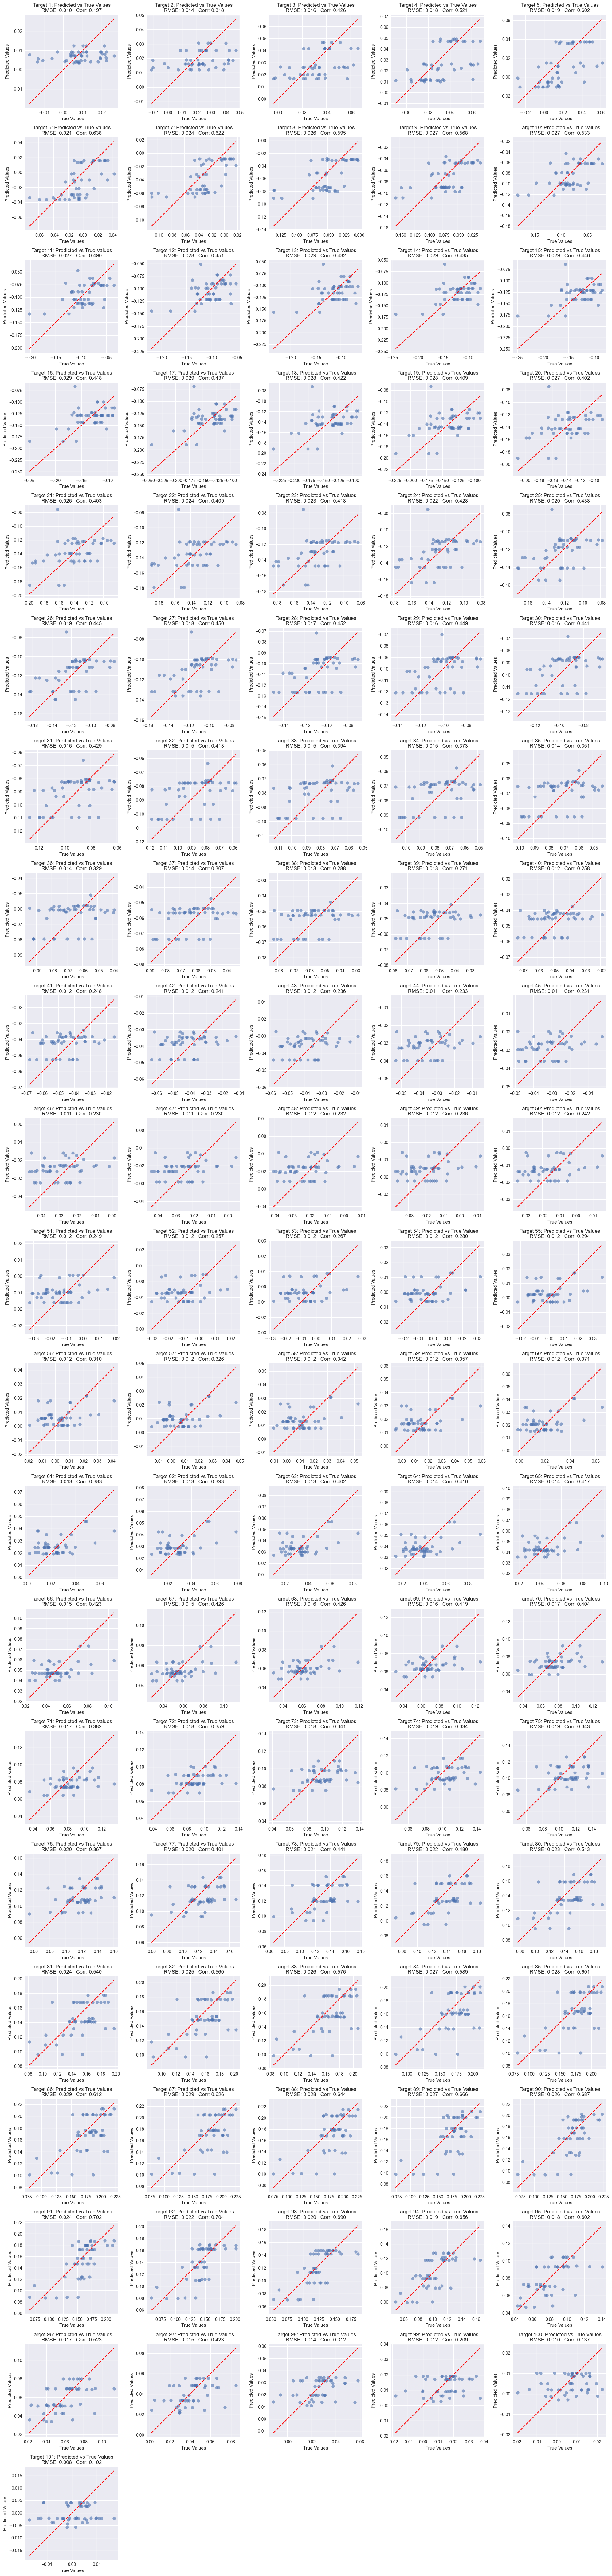

In [48]:
# Model 6 (Decision Tree Regressor):
plot_predictions_vs_true(y_true=y_test_A2, 
                         y_pred=y_pred_test_A2, 
                         rmse_scores_test = rmse_scores_test_A2,
                         corr_target_test = corr_target_test_A2)

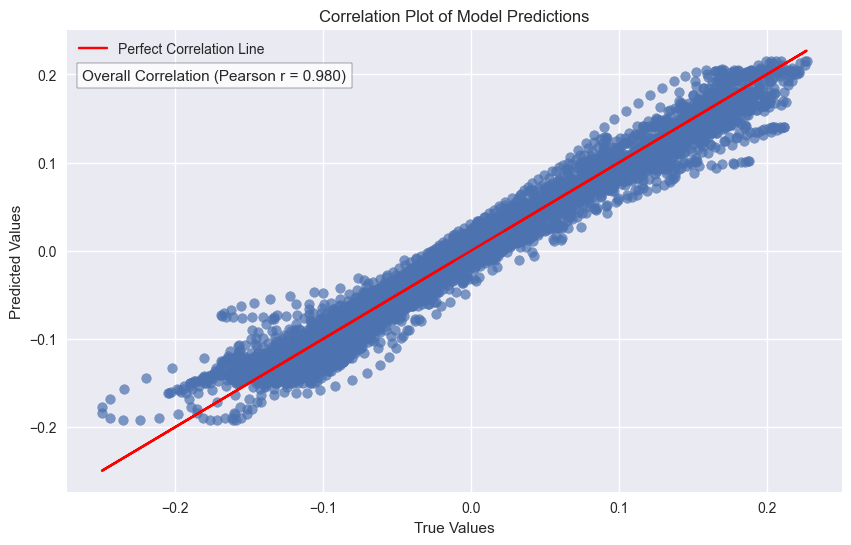

In [49]:
# Model 6 (Decision Tree Regressor): global correlation plot of the model's predictions with all points and the perfect correlation line.
plot_correlation_model(y_true=y_test_A2, y_pred=y_pred_test_A2, overall_corr_coeff=overall_corr_test_A2)

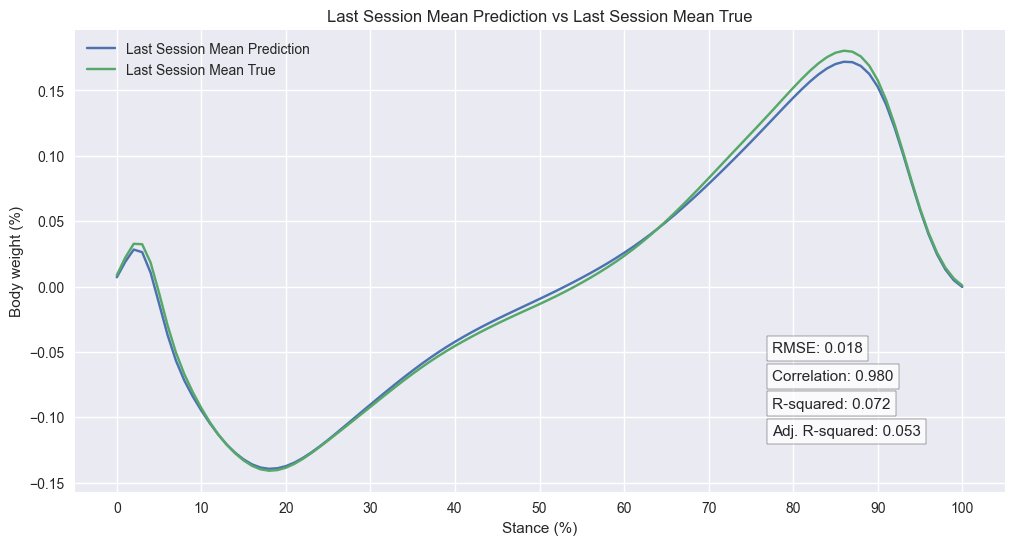

In [50]:
# Model 6 (Decision Tree Regressor):
plot_last_session_mean_prediction_vs_mean_true(y_true = y_test_A2, 
                                               y_pred = y_pred_test_A2, 
                                               overall_rmse = overall_rmse_test_A2,
                                               overall_corr = overall_corr_test_A2,
                                               overall_r2 = overall_R2_test_A2,
                                               overall_adj_r2 = overall_adj_R2_test_A2,
                                               time_points = 101,
                                               x_ticks= 10)

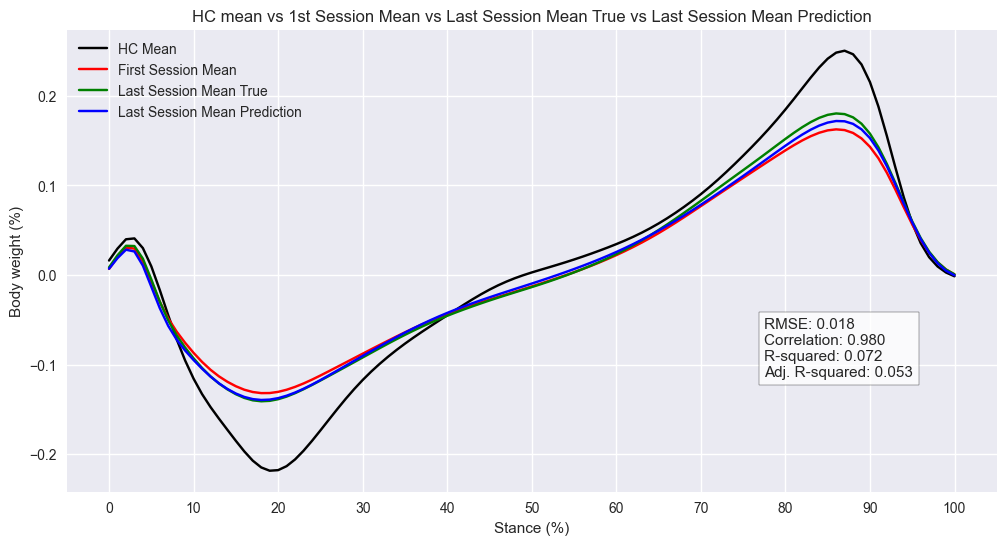

In [51]:
#### Model 6 (Decision Tree Regressor):
plot_system_output(hc_means = calculate_HC_mean(group = 'A', num_sessions = 2), 
                    first_session = X_test_A2, 
                    y_true = y_test_A2, 
                    y_pred = y_pred_test_A2, 
                    overall_rmse = overall_rmse_test_A2,
                    overall_corr = overall_corr_test_A2,
                    overall_r2 = overall_R2_test_A2,
                    overall_adj_r2 = overall_adj_R2_test_A2,
                    time_points = 101)

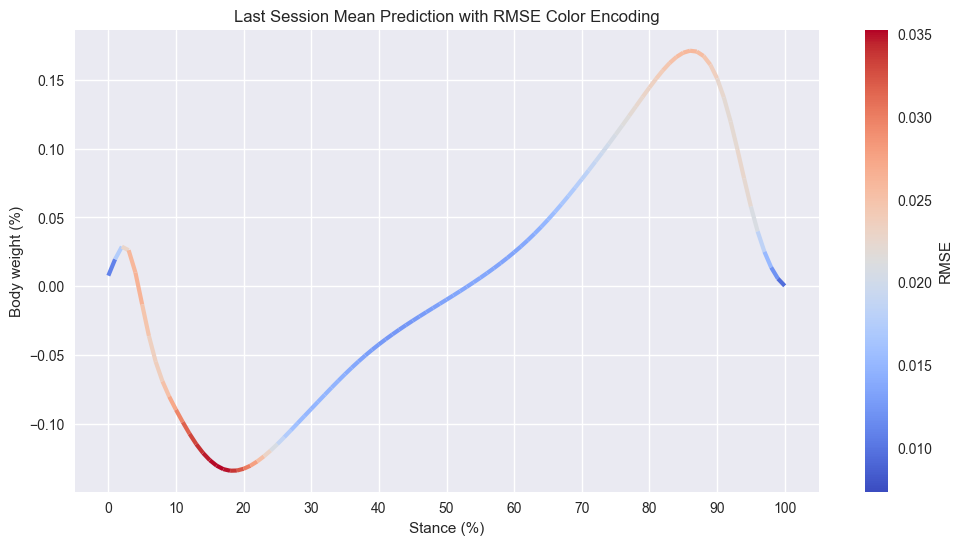

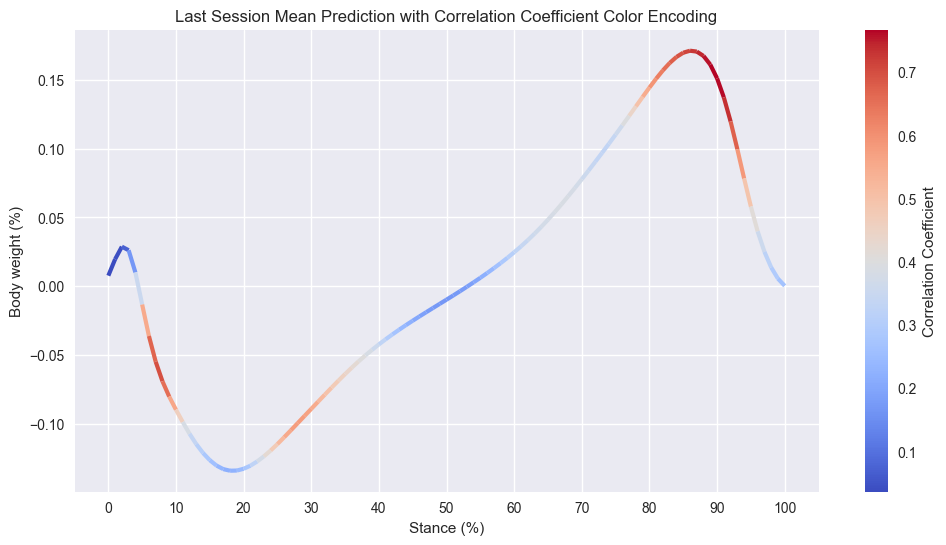

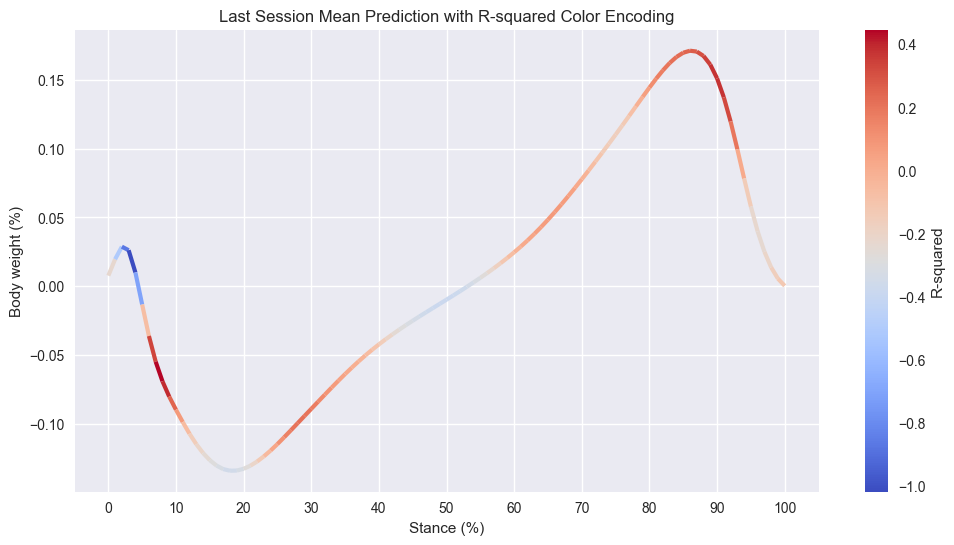

In [28]:
# Model 6 (Decision Tree Regressor): plot last session mean prediction with RMSE color encoding
plot_last_session_mean_prediction_with_rmse(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2, 
                                            rmse_scores_test=rmse_scores_test_A2,
                                            time_points=101)

# Model 6 (Decision Tree Regressor): plot last session mean prediction with correlation coefficient color encoding
plot_last_session_mean_prediction_with_corr(y_true=y_test_A2, 
                                            y_pred=y_pred_test_A2, 
                                            corr_target_test=corr_target_test_A2)
                                                  
# Model 6 (Decision Tree Regressor): plot last session mean prediction with R-squared color encoding
plot_last_session_mean_prediction_with_r2(y_true=y_test_A2, 
                                          y_pred=y_pred_test_A2, 
                                          r_squared=R2_target_test_A2)